# 13.2章 追跡フィルタの性能予測

追跡フィルタの性能予測には、しばしば共分散解析（Covariance Analysis）が用いられる。共分散解析における評価指標は、次の無次元パラメータであらわされる。

$$
P_1 = \frac{ \tau_m }{ T } ,\quad
P_2 = \frac{ T^2 \sigma_m }{ \sigma_o }, \quad
P_3 = \frac{ T \sigma_{ov} }{ \sigma_o }
$$

ここで、$\tau_m$と$\sigma_m$は、目標機動をSinger Accelaration Modelで定義した時の時定数と標準偏差、$\sigma_o$と$\sigma_{ov}$は、観測位置の標準偏差と観測速度の標準偏差、$T$はサンプル時間間隔である。なお、$P_3$は、速度計測が有効なシステムで用いられる。

この指標によって求められる値と、シミュレーションによって求められる追跡フィルタの予測誤差を比較してみる。

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.precision = 2

In [2]:
data = np.array([
    [1.00, 150., 10/1.00, 0.1, 0.03, 139, 51, 12.6],
    [3.16, 150., 10/3.16, 1.0, 0.11, 293, 77, 12.4],
    [5.00, 37.5, 10/5.00, 10., 0.67, 253, 44, 13.7]
])

df_paper = pd.DataFrame(data)
df_paper.columns = ['T(sec)', 'sigma_o(m)', 'p1', 'p2', 'p3', 'RMSE Position(m)', 'RMSE Velocity(m/s)', 'RMSE Acceleration(m/s2)']

data = np.array([
    [1.00, 150., 10/1.00, 0.1, 0.03, 36, 9.6,  8.4],
    [3.16, 150., 10/3.16, 1.0, 0.11, 65,  28, 11.4],
    [5.00, 37.5, 10/5.00, 10., 0.67, 111, 47, 12.7]
])

df_paper_vel = pd.DataFrame(data)
df_paper_vel.columns = df_paper.columns

In [3]:
import sys
sys.path.append('../')
import models
import sensors

def calc_rsme(tm, sm, dT, so, sov=0.0, is_vel_measure_enabled=False):
    if is_vel_measure_enabled:
        R=np.diag([so**2, sov**2])
    else:
        R=np.diag([so**2])
       
    eval = models.ModelEvaluator(
        models.SingerModelFactory(
            models.KalmanModel,
            tm=tm,
            sm=sm,
            SD=1,
            is_vel_measure_enabled=is_vel_measure_enabled
        ),
        models.SingerTarget(
            tm=tm,
            sm=sm
        ),
        R=R,
        sensor=sensors.BaseSensor(dT=dT)
    )
    rsme = eval.estimate_prediction_error()
    row = pd.Series( [dT, so, tm/dT, dT*dT*sm/so, dT*sov/so, rsme[0], rsme[1], rsme[2]], index=df_paper.columns)
    return (row, eval)

row_1, _ = calc_rsme(10, 15, 1, 150)
row_2, _ = calc_rsme(10, 15, 3.16, 150)
row_3, _ = calc_rsme(10, 15, 5, 37.5)

df_sim = pd.DataFrame(columns=df_paper.columns)
df_sim = df_sim.append(row_1, ignore_index=True)
df_sim = df_sim.append(row_2, ignore_index=True)
df_sim = df_sim.append(row_3, ignore_index=True)

row_1, _ = calc_rsme(10, 15, 1, 150, 5, True)
row_2, _ = calc_rsme(10, 15, 3.16, 150, 5, True)
row_3, eval = calc_rsme(10, 15, 5, 37.5, 5, True)

df_sim_vel = pd.DataFrame(columns=df_paper.columns)
df_sim_vel = df_sim_vel.append(row_1, ignore_index=True)
df_sim_vel = df_sim_vel.append(row_2, ignore_index=True)
df_sim_vel = df_sim_vel.append(row_3, ignore_index=True)

共分散解析と二乗平均平方根誤差(RSME)について、文献と本プログラムで比較検証した。  
  
位置計測のみのシステムにおける比較を示す。（上段：文献値、下段：計算値）  
＊＊＊  
＊＊＊  
＊＊＊  　

In [4]:
df_paper

,T(sec),sigma_o(m),p1,p2,p3,RMSE Position(m),RMSE Velocity(m/s),RMSE Acceleration(m/s2)
0,1.00,150.0,10.00,0.1,0.03,139.0,51.0,12.6
1,3.16,150.0,3.16,1.0,0.11,293.0,77.0,12.4
2,5.00,37.5,2.00,10.0,0.67,253.0,44.0,13.7


In [5]:
df_sim

,T(sec),sigma_o(m),p1,p2,p3,RMSE Position(m),RMSE Velocity(m/s),RMSE Acceleration(m/s2)
0,1.00,150.0,10.00,0.1,0.0,143.93,52.32,13.28
1,3.16,150.0,3.16,1.0,0.0,294.54,77.80,13.85
2,5.00,37.5,2.00,10.0,0.0,244.43,75.04,13.62


続いて、位置計測および速度計測のシステムにおける比較を示す。（上段：文献値、下段：計算値）  
＊＊＊  
＊＊＊  
＊＊＊  　

In [6]:
df_paper_vel

,T(sec),sigma_o(m),p1,p2,p3,RMSE Position(m),RMSE Velocity(m/s),RMSE Acceleration(m/s2)
0,1.00,150.0,10.00,0.1,0.03,36.0,9.6,8.4
1,3.16,150.0,3.16,1.0,0.11,65.0,28.0,11.4
2,5.00,37.5,2.00,10.0,0.67,111.0,47.0,12.7


In [7]:
df_sim_vel

,T(sec),sigma_o(m),p1,p2,p3,RMSE Position(m),RMSE Velocity(m/s),RMSE Acceleration(m/s2)
0,1.00,150.0,10.00,0.1,0.03,32.23,10.34,9.67
1,3.16,150.0,3.16,1.0,0.11,77.18,34.99,13.31
2,5.00,37.5,2.00,10.0,0.67,160.30,62.16,14.39


以上より、本プログラムが文献値とおおむね一致し、本プログラムの妥当性が得られた。  
続いて、各パラメータをランダムに変化させた時の共分散解析の無次元パラメータと二乗平均平方根誤差の関係性をプロットしてみる。
なお、パラメータは以下の範囲で変更する。

$$
\sigma_o = 10 ～ 500 m\\
\sigma_m = 5 ～ 30 m/s^2\\
\tau_m > 10 sec\\
T = 0.1 ～ 5.0 sec
$$

In [8]:
n_sample = 20
so_list = np.random.rand(n_sample)* 490 + 10
sm_list = np.random.rand(n_sample)* 25 + 5
tm_list = np.random.rand(n_sample)* 30 + 10
dT_list = np.random.rand(n_sample)* 4.9 + 0.1

df_param = pd.DataFrame(columns=df_paper.columns)
for so, sm, tm, dT in zip(so_list, sm_list, tm_list, dT_list):
    row, _ = calc_rsme(tm, sm, dT, so)
    df_param = df_param.append(row, ignore_index=True)

<IPython.core.display.Javascript object>


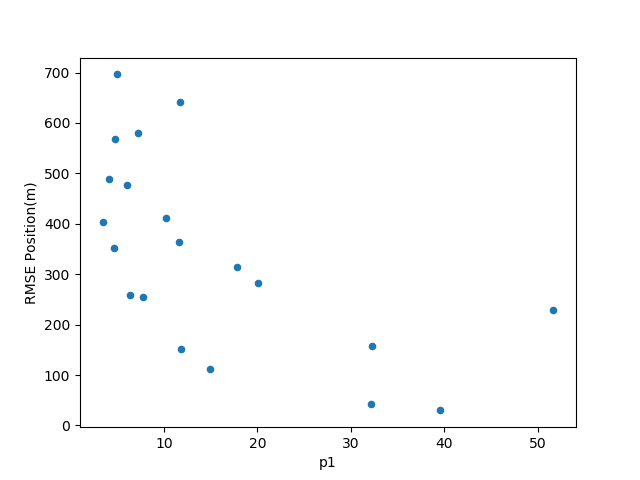

In [9]:
df_param.plot(x='p1', y='RMSE Position(m)', kind='scatter')

<IPython.core.display.Javascript object>


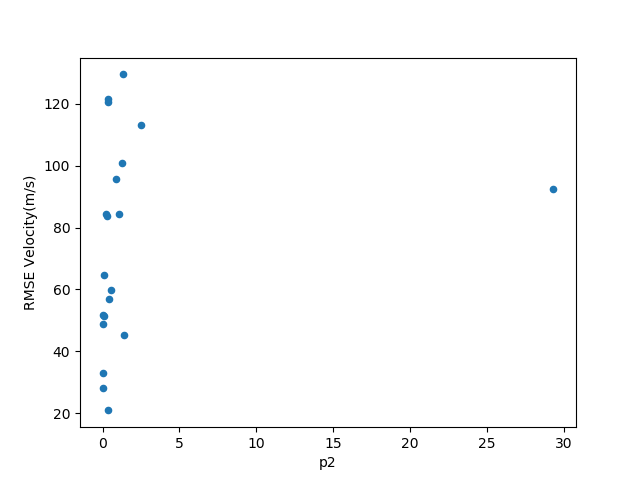

In [10]:
df_param.plot(x='p2', y='RMSE Velocity(m/s)', kind='scatter')

以上より、共分散解析のパラメータとRSMEの相関関係は見いだせなかった。このあたりは他文献などで要検証である。